## **Reinforcement Learning: Function Approx and SARSA control**


In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from collections import defaultdict
import math
import random

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
env = gym.make('MountainCar-v0')

In [ ]:
# StateSpace : {Car Position, Car Velocity}
stateSpaceSize = env.observation_space
print(stateSpaceSize)

Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)


In [ ]:
# ActionSpace: {0: Left, 1: Stop, 2: Right}
actionSpaceSize = env.action_space.n
print(actionSpaceSize)

3


In [ ]:
# Round State 0 to [-1.2, -1.1, ..., 0.5, 0.6] -> 19
# Round State 1 to [-0.07, -0.06, ..., 0.06, 0.07] -> 15

def round_state(state) :
  state[0] = round(state[0],1)
  state[1] = round(state[1],2)
  return state

In [ ]:
# Uniformly initial the Q for all the States

def initial_Q(Q):
  current_state_zero = -1.2
  for i in range (19) :
    current_state_one = -0.07
    for k in range (15) :
      Q[(round(current_state_zero,1),round(current_state_one,2))] = np.random.uniform(-1,1,3)
      current_state_one += 0.01
    current_state_zero += 0.1
  return Q

In [ ]:
env.reset()
action = env.action_space.sample()
obs, reward, done, info = env.step(action)
print("obs=",obs,"reward=",reward,"done=",done,"info=",info)

state = tuple(round_state(obs))
Q = defaultdict(lambda: np.zeros(actionSpaceSize))
Q[state][action] = 1
Q

obs= [-0.4082256  -0.00186124] reward= -1.0 done= False info= {}


defaultdict(<function __main__.<lambda>>, {(-0.4, -0.0): array([1., 0., 0.])})

In [ ]:
env = gym.make('MountainCar-v0')
env.reset()
sum_reward = 0

for i in range(200):
  action = env.action_space.sample()
  # print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  # print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
  sum_reward += reward

  if done:
    break
    
env.close()
print("Iterations that were run:",i, "Sum Reward is", sum_reward)

Iterations that were run: 199 Sum Reward is -200.0


## **n-Step SARSA**

In [ ]:
def n_step_Sarsa(env, max_episodes, alpha, gamma, epsilon, n):
  ## initial Q
  Q = initial_Q({})
  total_sum_reward = 0
  sum_reward = 0
  avg_reward = []

  ## Loop for each episode
  for e in range(max_episodes) :

    state_list = []
    action_list = []
    reward_list = []

    ## Initial the State 0
    state = env.reset()
    state = tuple(round_state(state))
    state_list.append(state)
    reward_list.append(-1)

    ## Update the epsilon, we tend to explore at the beginning 
    ## We reduce the epsilon to take the best action to explore more
    current_epsilon = epsilon * (1 - e/max_episodes)

    ## Choose A from S using epsilon greedy policy
    rand = rand = random.random()
    if rand < 1-current_epsilon: 
      action = np.argmax(Q[state])
    else:
      action = np.random.choice(np.arange(actionSpaceSize))
    
    action_list.append(action)
    T = math.inf

    for t in range(199):
      if t < T:
        action = action_list[t]
        next_state, reward, done, info = env.step(action)
        next_state = tuple(round_state(next_state))

        state_list.append(next_state)
        reward_list.append(reward)

        if done: T = t+1
        else: 
          ## Choose A' from S' using epsilon greedy policy
          rand = rand = random.random()
          if rand < 1-current_epsilon: 
            next_action = np.argmax(Q[next_state])
          else:
            next_action = np.random.choice(np.arange(actionSpaceSize))

          action_list.append(next_action)

      tau = t - n + 1

      if tau >=0:
        G = 0
        for i in range(int(np.min([T, tau+n])-(tau+1)+1)):
          G+= gamma**(i)*reward_list[tau+1+i]
        if tau+n < T: 
          G+=gamma**(n)* Q[state_list[tau+n]][action_list[tau+n]]
        Q[state_list[tau]][action_list[tau]]+=alpha*(G-Q[state_list[tau]][action_list[tau]])
      
      sum_reward += reward
      total_sum_reward += reward
      
      if tau == T-1: break

    if (e+1) % 100 == 0:
      avg = sum_reward/100
      #print("For episode",e+1,"Average Reward:", avg)
      avg_reward.append(avg)
      sum_reward = 0
  
  l = np.arange(100, max_episodes+1, 100).tolist()
  plt.plot(l,avg_reward)
  plt.xlabel("Episodes")
  plt.ylabel("Average Reward")

  print("Max Average Reward is", np.max(avg_reward), "Total Average Reward is", total_sum_reward/max_episodes)

  return Q

Max Average Reward is -156.62 Total Average Reward is -195.0887


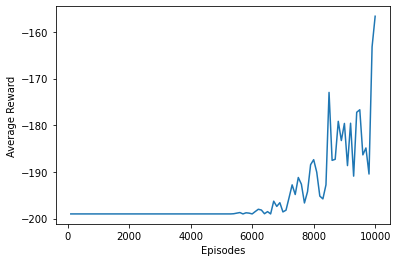

In [ ]:
Q = n_step_Sarsa(env, 10000, 0.2, 0.9, 0.8,4)

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error

In [ ]:
def Neural_Network(hidden=64, p_inputSpace =1, p_outputSpace=1):
  model=Sequential()
  model.add(Dense(hidden,input_shape=(p_inputSpace,), activation="relu"))
  model.add(Dense(hidden, activation="relu"))
  model.add(Dense(p_outputSpace, activation="linear"))
  return model

model = Neural_Network()
model.summary()
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                128       
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# optimizer and per-prediction error
alpha = 0.001
optimizer=tf.keras.optimizers.SGD(learning_rate=alpha)
f_ppError = keras.losses.MeanSquaredError()

In [ ]:
# training data (plotted at the end of this file)
train = np.array([[-2,-10], [-1,-5], [0, 0], [1,5], [2,10]])
x_train = train[:,0]
y_train = train[:,1]
# for stochastic gradient descent, create batches
batch_size = 1
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

epochs = 40
for epoch in range(epochs):
  #print("\nStart of epoch %d" % (epoch,))
  for step, (x_batch_train,y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      predictions = model(x_batch_train,training=True)
      ppError = f_ppError(y_batch_train,predictions)
    grads = tape.gradient(ppError,model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    print("Error: %f" % float(ppError))

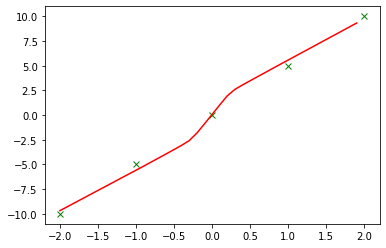

In [ ]:
D=np.arange(-2,2,.1)
R=model.predict(D)
from matplotlib import pyplot as plt
plt.plot(x_train,y_train,'gx',D,R,'r-')

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error

In [ ]:
## Input dimension 
p_inputSpace = env.observation_space.shape[0]
## Output dimension
p_outputSpace = env.action_space.n
print("Input:", p_inputSpace, "Output:", p_outputSpace)

Input: 2 Output: 3


In [ ]:
def Neural_Network(hidden=64, p_inputSpace =2, p_outputSpace=3):
  model=Sequential()
  model.add(Dense(hidden,input_shape=(p_inputSpace,), activation="relu"))
  model.add(Dense(hidden, activation="relu"))
  model.add(Dense(p_outputSpace, activation="linear"))
  return model

model = Neural_Network()
model.summary()
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                192       
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 3)                 195       
                                                                 
Total params: 4,547
Trainable params: 4,547
Non-trainable params: 0
_________________________________________________________________


In [ ]:
state = env.reset()
model = Neural_Network(64,2,3)
#model.summary()
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
state = tf.convert_to_tensor([state])
action = np.argmax(model(state))
q_value = model(state)
mask = tf.one_hot(action, actionSpaceSize)
#tf.convert_to_tensor([model(state.reshape((1, 2))).numpy()[0][1]])
#model(np.array(x_train))
tf.reduce_sum(tf.multiply(q_value, mask), axis=1)
tf.reduce_max(q_value, axis=1)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.00960813], dtype=float32)>

In [ ]:
def Semi_Gradient_On_Policy_Sarsa(env, max_episodes, alpha, gamma, epsilon):

  sum_reward = 0
  total_sum_reward = 0
  avg_reward = []

  # optimizer and per-prediction error
  optimizer=tf.keras.optimizers.SGD(learning_rate=alpha)
  f_ppError = keras.losses.MeanSquaredError()

  model = Neural_Network(64,p_inputSpace,p_outputSpace)
  model.compile(loss="mse", optimizer=optimizer)

  ## < ----------  Loop for each step of episode:  ---------- > 
  for e in range(max_episodes) :

    ## < ----------  Initial State  ---------- > 
    state = env.reset()
    state = tuple(round_state(state))
    state = tf.convert_to_tensor([state])

    ## Update the epsilon, we tend to explore at the beginning 
    ## We reduce the epsilon to take the best action to explore more
    current_epsilon = epsilon * (1 - e/max_episodes)

    ## < ----------  Choose A from S using epsilon greedy policy   ---------- > 
    rand = rand = random.random()
    if rand < 1-current_epsilon: 
      action = np.argmax(model(state))
    else:
      action = np.random.choice(np.arange(actionSpaceSize))

    ## < ----------  Loop for each step of episode:  ---------- > 
    for i in range(200):

      ## < ----------  Take action A and observe R, S'  ---------- > 
      next_state, reward, done, info = env.step(action)

      reward = tf.convert_to_tensor([reward])
      next_state = tuple(round_state(next_state))
      next_state = tf.convert_to_tensor([next_state])
      done = tf.convert_to_tensor(done)

      ## < ----------  If S' is terminal  ---------- > 
      if done:
        target_q = reward
        action_mask = tf.one_hot(action, actionSpaceSize)
        with tf.GradientTape() as tape:
          tape.watch(model.trainable_variables)
          q_value = model(state)
          q_value_mask = tf.reduce_sum(tf.multiply(q_value, action_mask), axis=1)
          ppError = f_ppError(target_q,q_value_mask)

        grads = tape.gradient(ppError,model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        sum_reward += reward
        total_sum_reward += reward
        break

      ## < ----------  Choose A' from S' using epsilon greedy policy   ---------- >
      rand = random.random()
      if rand < 1-current_epsilon: 
        next_action = np.argmax(np.argmax(model(next_state)))
      else:
        next_action = np.random.choice(np.arange(actionSpaceSize))

      future_reward = model(next_state)
      next_action_mask = tf.one_hot(next_action, actionSpaceSize)
      target_q = reward + gamma * tf.reduce_sum(tf.multiply(future_reward, next_action_mask), axis=1)

      action_mask = tf.one_hot(action, actionSpaceSize)

      with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        q_value = model(state)
        q_value_mask = tf.reduce_sum(tf.multiply(q_value, action_mask), axis=1)
        ppError = f_ppError(target_q,q_value_mask)
      #if (i+1) % 50 == 0:
      #  print("Error: %f" % float(ppError))

      grads = tape.gradient(ppError,model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

      #Q[state][action] = Q[state][action] + alpha*(reward+gamma*Q[next_state][next_action]-Q[state][action])

      state = next_state
      action = next_action
      sum_reward += reward
      total_sum_reward += reward

    if (e+1) % 10 == 0:
      #print(sum_reward)
      avg = int(sum_reward.numpy())/10
      print("For episode",e+1,"Average Reward:", avg)
      avg_reward.append(avg)
      sum_reward = 0
  
  l = np.arange(10, max_episodes+1, 10).tolist()
  plt.plot(l,avg_reward)
  plt.xlabel("Episodes")
  plt.ylabel("Average Reward")

  print("Max Average Reward is", np.max(avg_reward), "Total Average Reward is", int(total_sum_reward.numpy())/max_episodes)

  return model

In [ ]:
Q = Semi_Gradient_On_Policy_Sarsa(env, 500, 0.001, 0.9, 0.8)

Error: 0.854662
Error: 0.958420
Error: 0.948844
Error: 0.899442
Error: 0.821046
Error: 0.732727
Error: 0.773198
Error: 0.726907
Error: 0.734672
Error: 1.783482
Error: 0.136724
Error: 0.004005
Error: 5.176349
Error: 0.258757
Error: 0.357374
Error: 0.085771
Error: 0.081509
Error: 0.505699
Error: 0.031009
Error: 0.000804
Error: 0.302266
Error: 0.000317
Error: 0.001367
Error: 0.056773
Error: 0.002331
Error: 0.004261
Error: 0.003091
Error: 0.002539
Error: 0.000002
Error: 0.009995


**By tracking the gradient ppError, we can see that the error keep going down which means the network is learning.**

Max Average Reward is -170.09 Total Average Reward is -194.9232


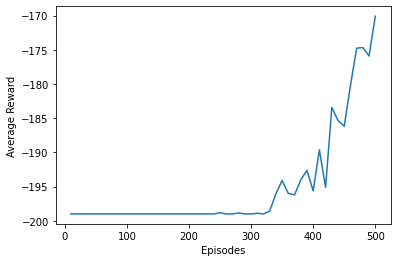

In [ ]:
Q = Semi_Gradient_On_Policy_Sarsa(env, 500, 0.001, 0.9, 0.8)

**After 500 episodes, we find that the reward start to raise after 300 episodes, which is much faster than n_step_Sarsa showed in previous part.**